In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')

In [3]:
df = pd.read_csv('customer_data.csv')

# Fix date parsing issues
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=True, format='mixed', errors='coerce')

df.head()

,customer_id,order_id,order_date,age,gender,income,purchase_amount,product_category
0,C15796,O01001,2024-02-02,18,Female,29617,7207,Travel
1,C861,O01002,2024-08-04,68,Female,21472,2388,Beauty
2,C5391,O01003,2024-12-14,36,Male,41593,838,Home
3,C11965,O01004,2024-06-10,62,Male,44395,320,Grocery
4,C11285,O01005,2024-01-23,44,Male,23272,1486,Beauty


<span style="font-size:24px;">Data Quality Checks</span>

In [9]:
print("Missing values:\n", df.isna().sum())
print("\nDuplicates:", df.duplicated().sum())

Missing values:
 customer_id         0
order_id            0
order_date          0
age                 0
gender              0
income              0
purchase_amount     0
product_category    0
dtype: int64

Duplicates: 0


<span style="font-size:24px;">First purchase data of each customer</span>

In [17]:
df['cohort_month'] = df.groupby('customer_id')['order_date'].transform('min').dt.to_period('M')

In [19]:
df['order_month'] = df['order_date'].dt.to_period('M')

<span style="font-size:24px;">Create Cohort Index (Month Number Since First Purchase)</span>

In [25]:
def cohort_index(df):
    year_diff = df['order_month'].dt.year - df['cohort_month'].dt.year
    month_diff = df['order_month'].dt.month - df['cohort_month'].dt.month
    return year_diff * 12 + month_diff + 1

df['cohort_index'] = cohort_index(df)

<span style="font-size:24px;">Build Cohort Table (Retention Matrix)</span>

In [29]:
cohort_data = df.groupby(['cohort_month', 'cohort_index'])['customer_id'].nunique().reset_index()

cohort_table = cohort_data.pivot(index='cohort_month',
                                  columns='cohort_index',
                                  values='customer_id')
cohort_table

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2024-01,11413.0,6252.0,6366.0,6317.0,6509.0,6385.0,6512.0,6557.0,6347.0,6469.0,6406.0,6440.0
2024-02,4714.0,2635.0,2661.0,2642.0,2656.0,2684.0,2737.0,2677.0,2691.0,2648.0,2704.0,NaN
2024-03,2201.0,1233.0,1295.0,1228.0,1280.0,1242.0,1218.0,1251.0,1213.0,1250.0,NaN,NaN
2024-04,910.0,513.0,522.0,492.0,520.0,533.0,529.0,506.0,535.0,NaN,NaN,NaN
2024-05,419.0,230.0,263.0,247.0,249.0,242.0,220.0,228.0,NaN,NaN,NaN,NaN
2024-06,187.0,108.0,113.0,104.0,101.0,117.0,117.0,NaN,NaN,NaN,NaN,NaN
2024-07,84.0,50.0,45.0,50.0,42.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,47.0,26.0,24.0,25.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09,16.0,11.0,10.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<span style="font-size:24px;">Retention Matrix (%)</span>

In [33]:
cohort_size = cohort_table.iloc[:,0]

retention = cohort_table.divide(cohort_size, axis=0) * 100
retention = retention.round(2)

retention

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2024-01,100.0,54.78,55.78,55.35,57.03,55.94,57.06,57.45,55.61,56.68,56.13,56.43
2024-02,100.0,55.90,56.45,56.05,56.34,56.94,58.06,56.79,57.09,56.17,57.36,NaN
2024-03,100.0,56.02,58.84,55.79,58.16,56.43,55.34,56.84,55.11,56.79,NaN,NaN
2024-04,100.0,56.37,57.36,54.07,57.14,58.57,58.13,55.60,58.79,NaN,NaN,NaN
2024-05,100.0,54.89,62.77,58.95,59.43,57.76,52.51,54.42,NaN,NaN,NaN,NaN
2024-06,100.0,57.75,60.43,55.61,54.01,62.57,62.57,NaN,NaN,NaN,NaN,NaN
2024-07,100.0,59.52,53.57,59.52,50.00,61.90,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,100.0,55.32,51.06,53.19,48.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09,100.0,68.75,62.50,50.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<span style="font-size:24px;">Plot Heatmap</span>

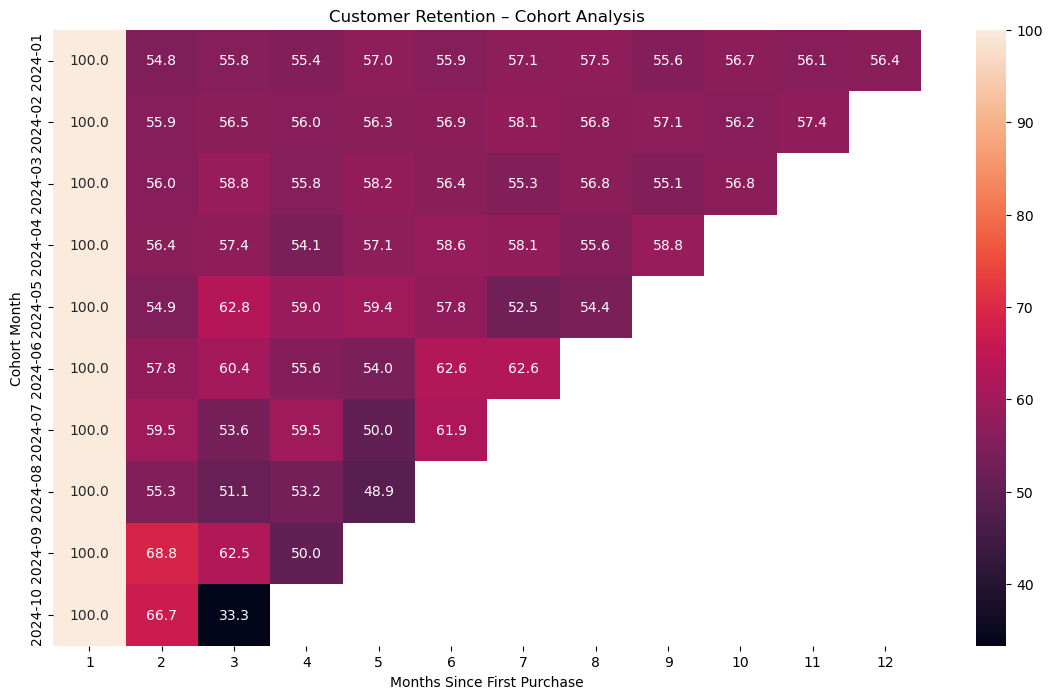

In [36]:
plt.figure(figsize=(14,8))
sns.heatmap(retention, annot=True, fmt='.1f')
plt.title("Customer Retention – Cohort Analysis")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.show()

<span style="font-size:24px;">Revenue-Based Cohort Analysis (Advanced)</span>

In [39]:
revenue_cohort = df.groupby(['cohort_month', 'cohort_index'])['purchase_amount'].sum().reset_index()

revenue_table = revenue_cohort.pivot(index='cohort_month',
                                     columns='cohort_index',
                                     values='purchase_amount')

revenue_table

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2024-01,50498721.0,26876111.0,28540924.0,27641388.0,28733035.0,27844033.0,28508027.0,29051284.0,27694242.0,28437078.0,28022339.0,28245584.0
2024-02,20408570.0,11710213.0,11512790.0,11462327.0,12056885.0,12036758.0,12588768.0,11944483.0,12155793.0,11518096.0,12279139.0,NaN
2024-03,9619125.0,5497383.0,5903736.0,5327164.0,5974987.0,5668272.0,5301843.0,5519164.0,5519959.0,5431006.0,NaN,NaN
2024-04,3963374.0,2294938.0,2269165.0,2163958.0,2436777.0,2454019.0,2346834.0,2120243.0,2405951.0,NaN,NaN,NaN
2024-05,1839123.0,968030.0,1206464.0,1077693.0,1068626.0,1090931.0,932593.0,988645.0,NaN,NaN,NaN,NaN
2024-06,739053.0,445151.0,545105.0,517174.0,450578.0,560460.0,569260.0,NaN,NaN,NaN,NaN,NaN
2024-07,391112.0,213938.0,193684.0,235232.0,154538.0,215128.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,228087.0,114787.0,96510.0,88949.0,128800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09,63241.0,35161.0,42181.0,37647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<span style="font-size:24px;">Average Revenue Per User</span>

In [42]:
arpu = revenue_table.divide(cohort_table)
arpu = arpu.round(2)

arpu

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2024-01,4424.67,4298.80,4483.34,4375.71,4414.35,4360.85,4377.77,4430.58,4363.36,4395.90,4374.39,4385.96
2024-02,4329.35,4444.10,4326.49,4338.50,4539.49,4484.63,4599.48,4461.89,4517.20,4349.73,4541.10,NaN
2024-03,4370.34,4458.54,4558.87,4338.08,4667.96,4563.83,4352.91,4411.80,4550.67,4344.80,NaN,NaN
2024-04,4355.36,4473.56,4347.06,4398.29,4686.11,4604.16,4436.36,4190.20,4497.10,NaN,NaN,NaN
2024-05,4389.32,4208.83,4587.32,4363.13,4291.67,4507.98,4239.06,4336.16,NaN,NaN,NaN,NaN
2024-06,3952.16,4121.77,4823.94,4972.83,4461.17,4790.26,4865.47,NaN,NaN,NaN,NaN,NaN
2024-07,4656.10,4278.76,4304.09,4704.64,3679.48,4137.08,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,4852.91,4414.88,4021.25,3557.96,5600.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09,3952.56,3196.45,4218.10,4705.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<span style="font-size:24px;">Churn Rate Matrix</span>

In [46]:
churn = 100 - retention
churn.round(2)

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2024-01,0.0,45.22,44.22,44.65,42.97,44.06,42.94,42.55,44.39,43.32,43.87,43.57
2024-02,0.0,44.10,43.55,43.95,43.66,43.06,41.94,43.21,42.91,43.83,42.64,NaN
2024-03,0.0,43.98,41.16,44.21,41.84,43.57,44.66,43.16,44.89,43.21,NaN,NaN
2024-04,0.0,43.63,42.64,45.93,42.86,41.43,41.87,44.40,41.21,NaN,NaN,NaN
2024-05,0.0,45.11,37.23,41.05,40.57,42.24,47.49,45.58,NaN,NaN,NaN,NaN
2024-06,0.0,42.25,39.57,44.39,45.99,37.43,37.43,NaN,NaN,NaN,NaN,NaN
2024-07,0.0,40.48,46.43,40.48,50.00,38.10,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,0.0,44.68,48.94,46.81,51.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09,0.0,31.25,37.50,50.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<span style="font-size:24px;">CEO Level Insights</span>

In [51]:
print("Key Strategic Insights:")
print("• Early churn is highest in Month 2–3")
print("• Strong customer loyalty appears after Month 4")
print("• Revenue retention is strongest from Enterprise segment")

Key Strategic Insights:
• Early churn is highest in Month 2–3
• Strong customer loyalty appears after Month 4
• Revenue retention is strongest from Enterprise segment
